In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
mpl.rc('font', **{'size': 14})

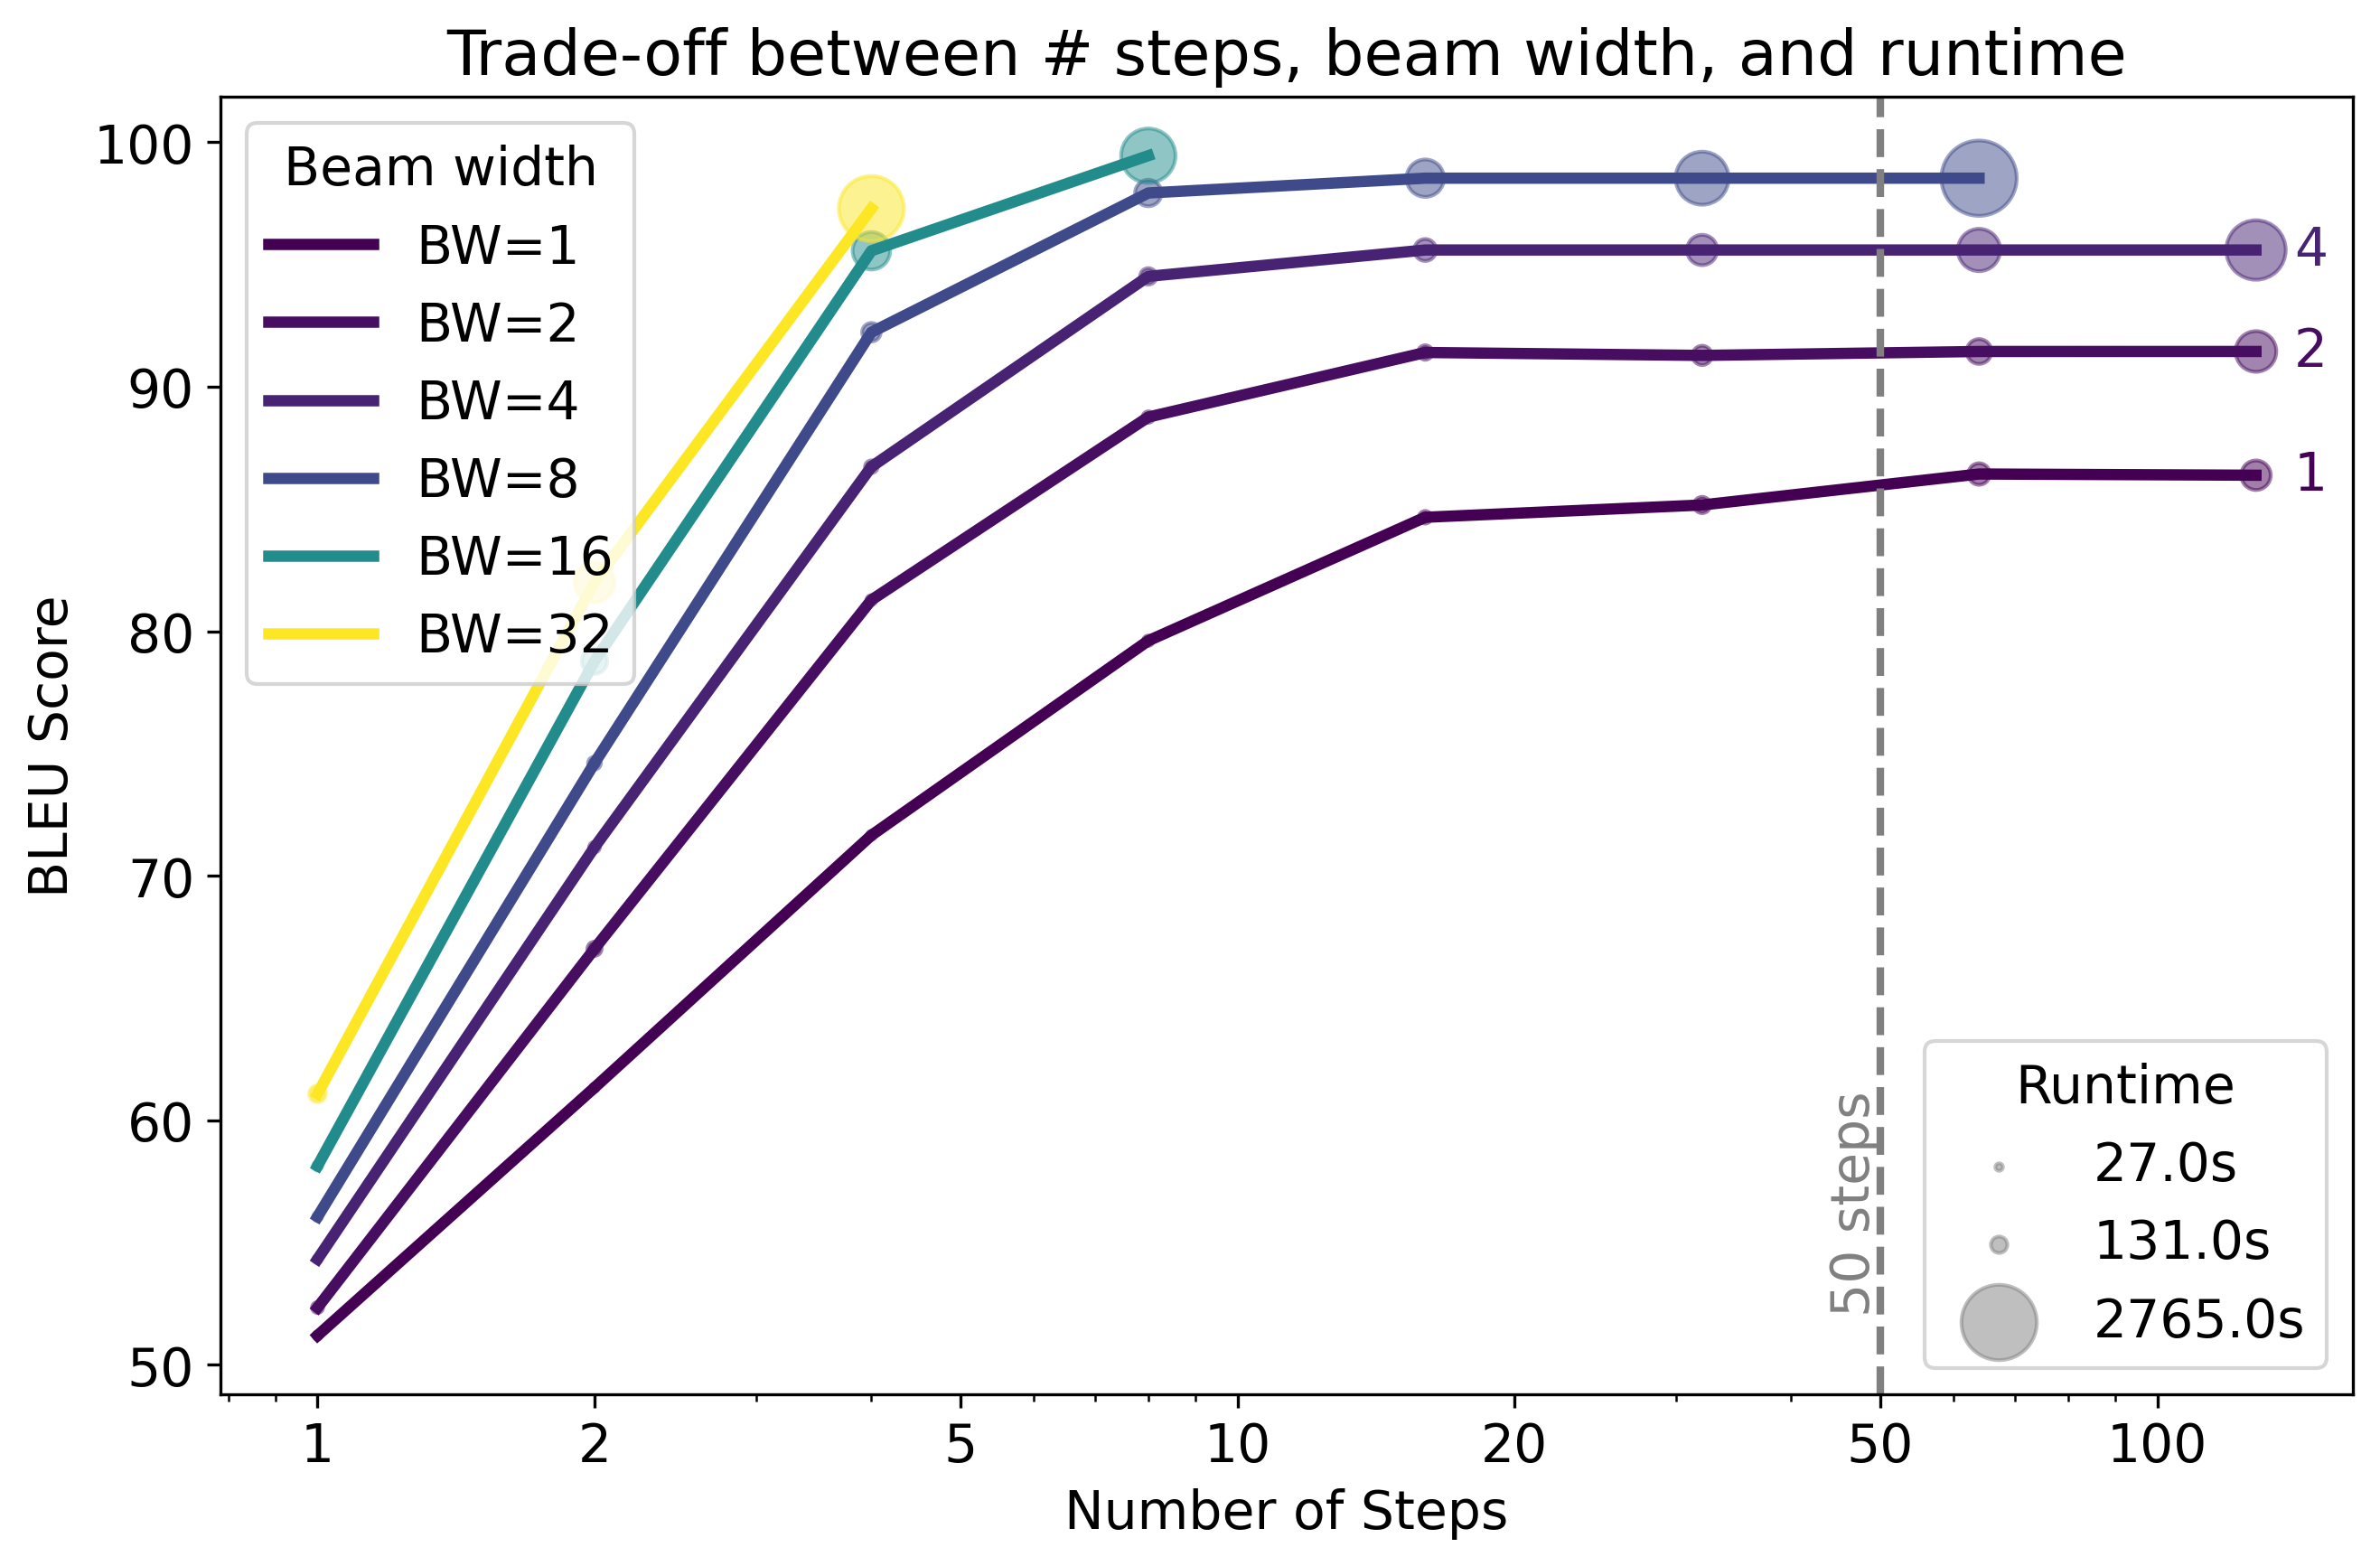

In [14]:
data = pd.read_csv("./data/num_steps_vs_beam_width.csv")
data = data[["num_steps", "sequence_beam_width", "bleu_score", "Runtime"]]

data.dropna(inplace=True)

data["num_steps"] = data["num_steps"].astype(int)
data["sequence_beam_width"] = data["sequence_beam_width"].astype(int)
data["Runtime"] = data["Runtime"].astype(float)

pivot_bleu = data.pivot_table(
    index="num_steps", columns="sequence_beam_width", values="bleu_score", aggfunc="mean"
)

pivot_runtime = data.pivot_table(
    index="num_steps", columns="sequence_beam_width", values="Runtime", aggfunc="mean"
)

pivot_bleu = pivot_bleu.sort_index().sort_index(axis=1)
pivot_runtime = pivot_runtime.reindex_like(pivot_bleu)

scale_factor = 100 / data["Runtime"].max()

#plt.style.use("seaborn-whitegrid")

bw_list = sorted(pivot_bleu.columns)
norm    = mpl.colors.Normalize(vmin=bw_list[0], vmax=bw_list[-1])
cmap    = plt.get_cmap("viridis")

plt.figure(figsize=(9,6), dpi=300)
for bw in bw_list:
    color = cmap(norm(bw))
    sizes = pivot_runtime[bw] * scale_factor * 4
    plt.plot(pivot_bleu.index, pivot_bleu[bw],
             color=color, label=f"BW={bw}", linewidth=3)
    plt.scatter(pivot_bleu.index, pivot_bleu[bw],
                s=sizes, alpha=0.5, color=color)
    # direct label at end
    plt.text(pivot_bleu.index.max()*1.1,
             pivot_bleu[bw].iloc[-1],
             str(bw), va="center", color=color)

# 50 steps annotation
plt.axvline(50, color="gray", ls="--", lw=2)
plt.text(50, 52, "50 steps", rotation=90,
         va="bottom", ha="right", color="gray")

# ticks & labels
plt.xscale("log")
plt.xticks([1,2,5,10,20,50,100], ["1","2","5","10","20","50","100"])
plt.xlabel("Number of Steps")
plt.ylabel("BLEU Score")
plt.title("Trade-off between # steps, beam width, and runtime")

# separate legends
l1 = plt.legend(title="Beam width", loc="upper left")
size_vals = [data["Runtime"].min(),
             data["Runtime"].median(),
             data["Runtime"].max()]
handles = [ plt.scatter([],[], s=rt*scale_factor*4, color="gray", alpha=0.5)
            for rt in size_vals ]
labels  = [f"{rt:.1f}s" for rt in size_vals]
l2 = plt.legend(handles, labels, title="Runtime", loc="lower right")
plt.gca().add_artist(l1)

plt.tight_layout()
plt.savefig("num_steps_vs_beam_width_runtime.pdf")
plt.show()



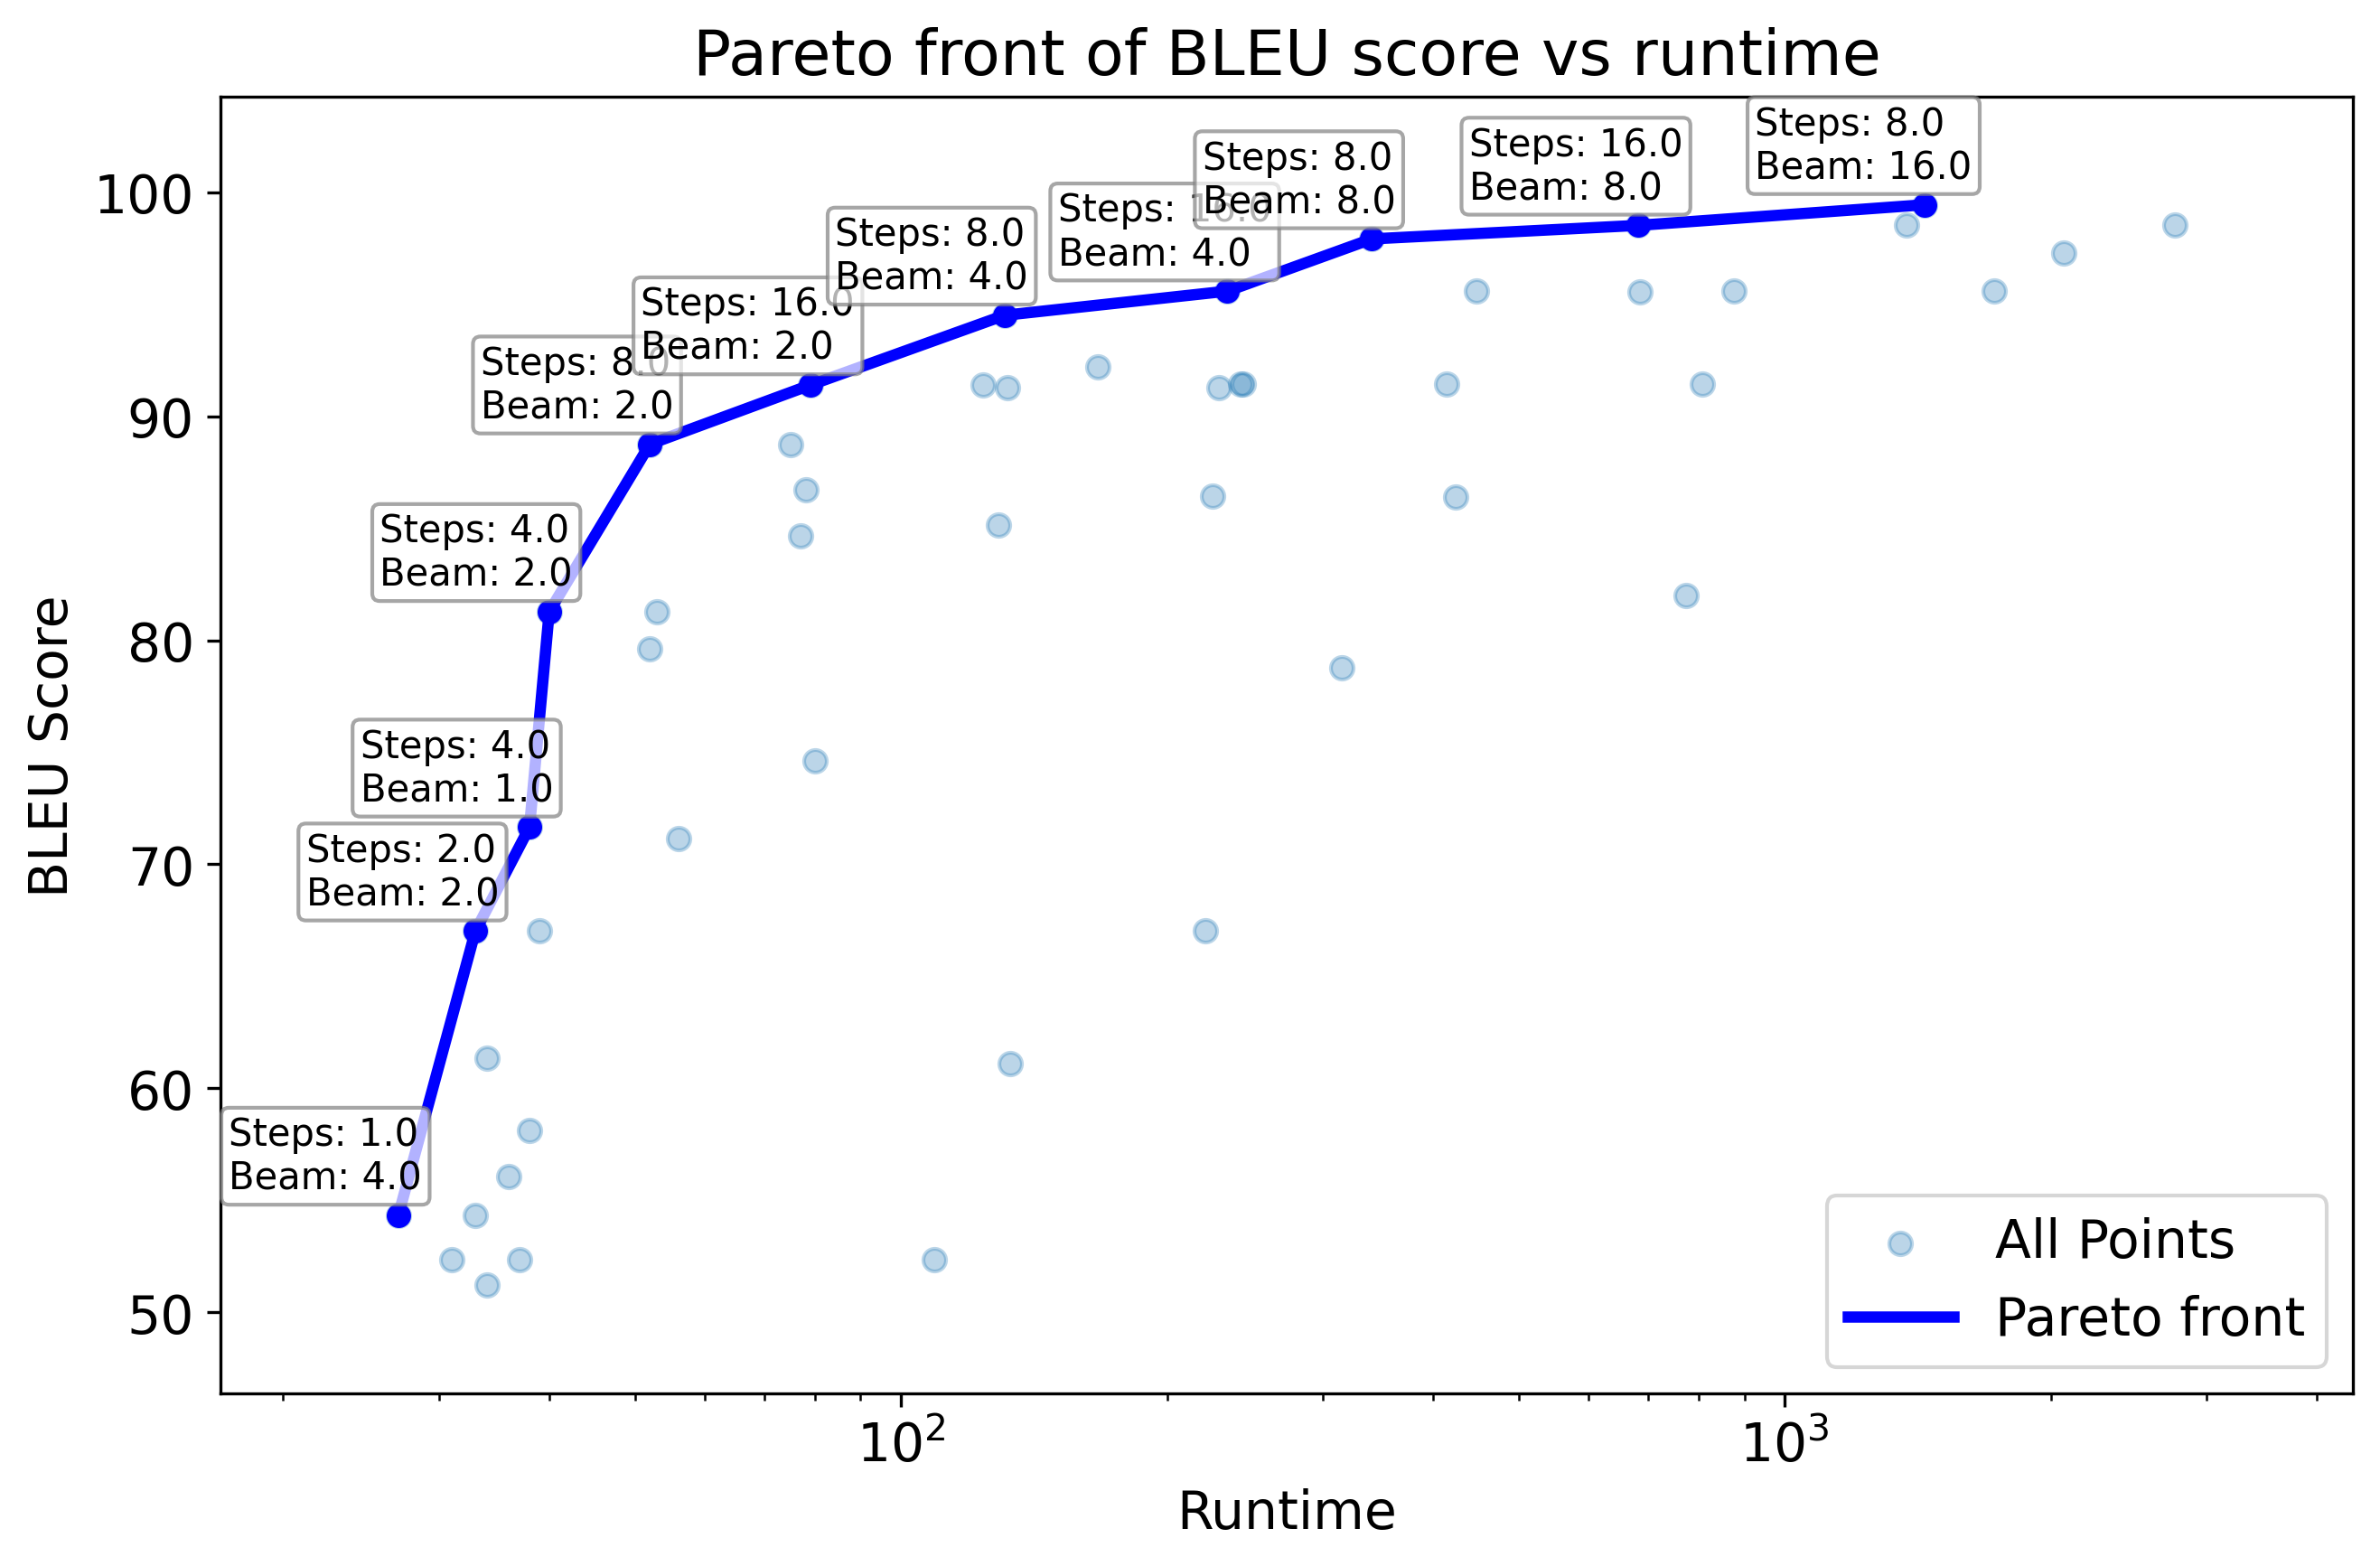

In [7]:
data = pd.read_csv("./data/num_steps_vs_beam_width.csv")
data = data[["num_steps", "sequence_beam_width", "bleu_score", "Runtime"]]

data.dropna(inplace=True)

data["num_steps"] = data["num_steps"].astype(int)
data["sequence_beam_width"] = data["sequence_beam_width"].astype(int)
data["Runtime"] = data["Runtime"].astype(float)

data_sorted = data.sort_values(["Runtime", "bleu_score"], ascending=[True, False])

pareto_front = []
last_bleu = -1
for _, row in data_sorted.iterrows():
    if row["bleu_score"] > last_bleu:
        pareto_front.append(row)
        last_bleu = row["bleu_score"]

pareto_front = pd.DataFrame(pareto_front)

fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

ax.scatter(data["Runtime"], data["bleu_score"], alpha=0.3, label="All Points")

ax.plot(
    pareto_front["Runtime"], pareto_front["bleu_score"], "b-", linewidth=3, label="Pareto front"
)
ax.scatter(pareto_front["Runtime"], pareto_front["bleu_score"], color="b", s=30)

for idx, row in pareto_front.iterrows():
    ax.annotate(
        f"Steps: {row['num_steps']}\nBeam: {row['sequence_beam_width']}",
        (row["Runtime"], row["bleu_score"]),
        textcoords="offset points",
        xytext=(-45, 7),
        ha="left",
        fontsize=10,               # make it a bit smaller if needed
        bbox=dict(boxstyle="round,pad=0.2", edgecolor="gray", facecolor="white", alpha=0.7),
        clip_on=False,            # let it draw outside the axes
    )

ax.set_xscale("log")
ax.set_xmargin(0.1)
ax.set_ymargin(0.1)

ax.set_xlabel("Runtime")
ax.set_ylabel("BLEU Score")
ax.set_title("Pareto front of BLEU score vs runtime")
ax.legend(loc="lower right")

plt.tight_layout()   # <-- adjust margins
plt.savefig("pareto_front_bleu_vs_runtime.pdf", bbox_inches="tight")
plt.show()


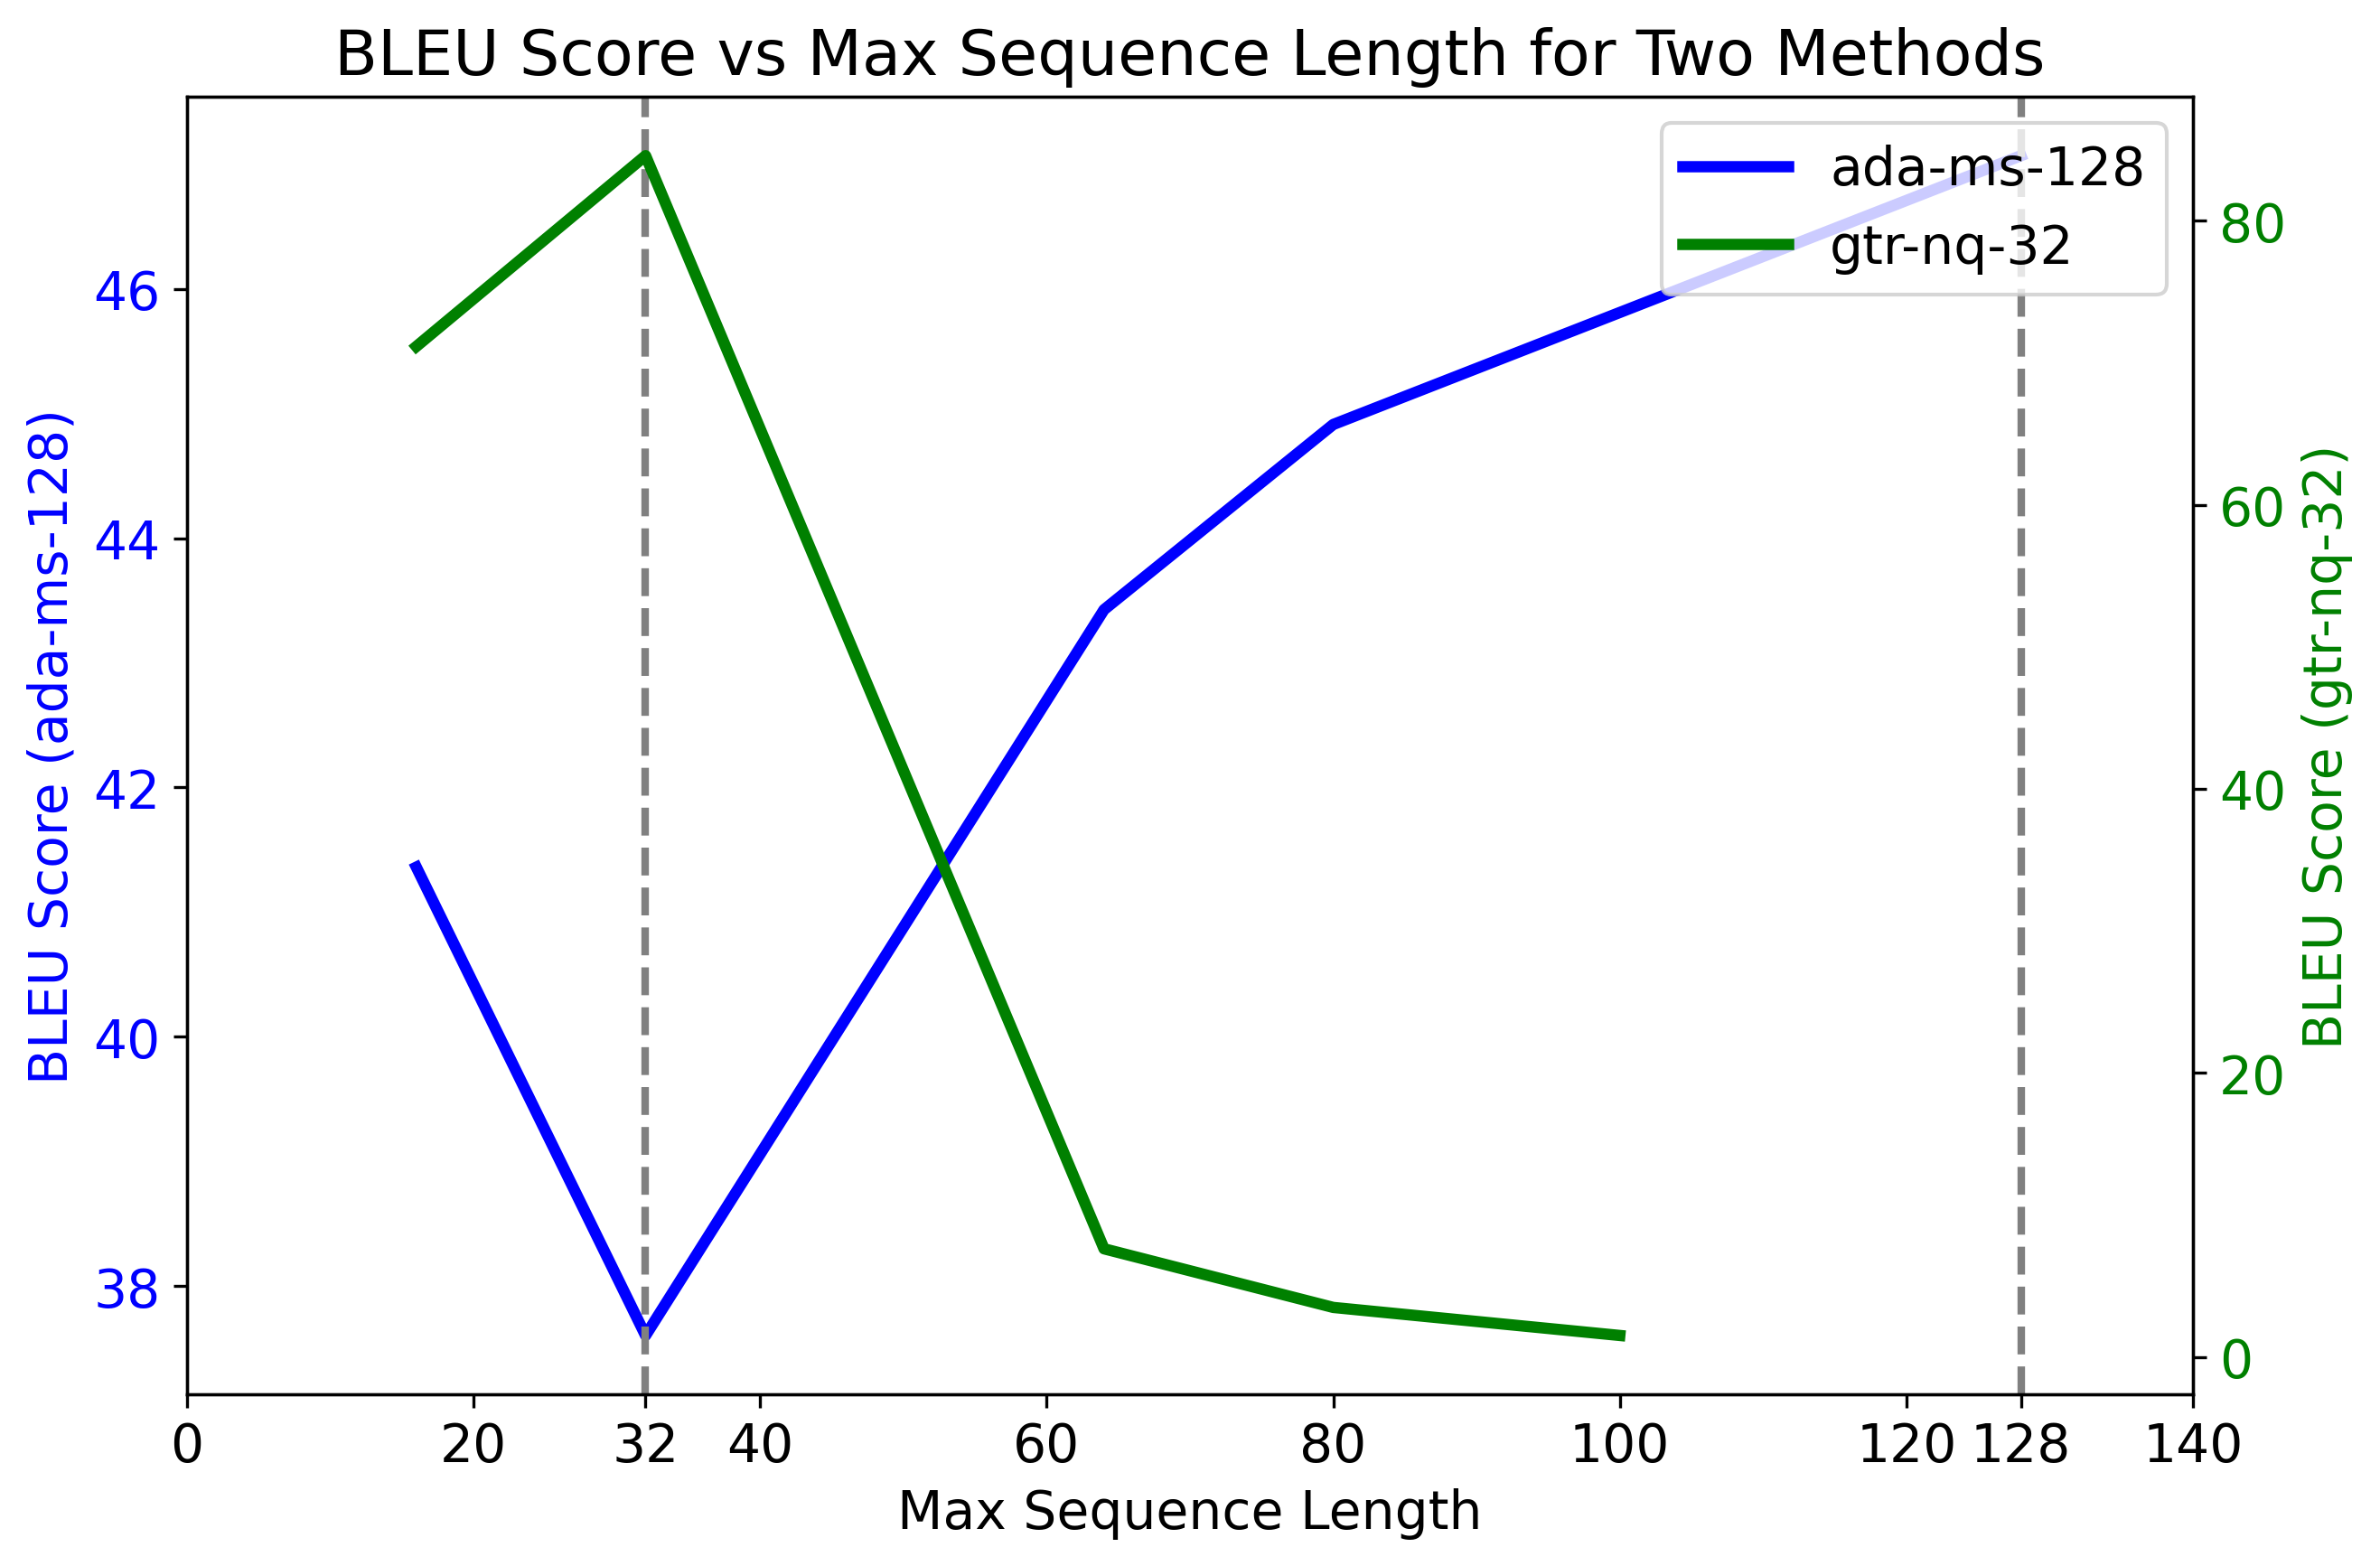

In [15]:
data = pd.read_csv("./data/seq_len_exps.csv")
name_map = {
    "model-sentence-transformers/gtr-t5-base_corrector-gtr-base_steps-50_beam-0_nucleus-False": "gtr-nq-32",
    "model-Xenova/text-embedding-ada-002_corrector-text-embedding-ada-002_steps-50_beam-0_nucleus-False": "ada-ms-128",
}
data["Name"] = data["Name"].map(name_map)
data["method"] = data["Name"]
data = data[["method", "max_seq_length", "bleu_score"]]

# Select two methods (assuming there are at least two)
methods = data['method'].unique()

# Create a figure and primary axis
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)

# Plot the first method as a line
method1 = methods[0]
method1_data = data[data['method'] == method1].sort_values(by="max_seq_length")
line1, = ax1.plot(method1_data["max_seq_length"], method1_data["bleu_score"], color='b', label=method1, linewidth=3)
ax1.set_xlabel("Max Sequence Length")
ax1.set_ylabel(f"BLEU Score ({method1})", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the second method as a line
method2 = methods[1]
method2_data = data[data['method'] == method2].sort_values(by="max_seq_length")
line2, = ax2.plot(method2_data["max_seq_length"], method2_data["bleu_score"], color='g', label=method2, linewidth=3)
ax2.set_ylabel(f"BLEU Score ({method2})", color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Combine the legends' handles and labels
lines = [line1, line2]
labels = [line1.get_label(), line2.get_label()]

# Create a combined legend from both axes
ax1.legend(lines, labels, loc='upper right')

# Add a title
plt.title("BLEU Score vs Max Sequence Length for Two Methods")

# Set custom x-ticks, including at 32 and 128
current_xticks = ax1.get_xticks().tolist()  # Get the current list of x-ticks
new_xticks = sorted(set(current_xticks + [32, 128]))  # Combine with new ticks and sort
ax1.set_xticks(new_xticks)

# Add dashed vertical lines at 32 and 128
ax1.axvline(x=32, color='gray', linestyle='--', linewidth=2)
ax1.axvline(x=128, color='gray', linestyle='--', linewidth=2)

# Show the plot
plt.tight_layout()
plt.savefig("seq_len_exps.pdf")
plt.show()